In [6]:
import sys
print(sys.executable)
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
print("Imported libs")

/Users/anton/Projects/internet-measurements/.venv/bin/python
Imported libs


In [7]:
# Load data
df = pl.read_csv("lisbon.csv")
print(df.head())

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ balancerI ┆ balancerI ┆ clientIpA ┆ … ┆ latencyTC ┆ latencyTL ┆ latencyFi ┆ latencyD │
│ ---       ┆ d         ┆ p         ┆ ccordingC ┆   ┆ P         ┆ S         ┆ rstByte   ┆ ownload  │
│ f64       ┆ ---       ┆ ---       ┆ loudflare ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ ---       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
│           ┆           ┆           ┆ str       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.7690e9  ┆ 107f211   ┆ 104.16.13 ┆ 185.32.19 ┆ … ┆ 3         ┆ 46        ┆ 15        ┆ 6        │
│           ┆           ┆ 3.229     ┆ 0.187     ┆   ┆           ┆           ┆           ┆          │
│ 1.7690e9  ┆ 107f156   ┆ 104.16.13 ┆ 185.32.19 ┆ … ┆ 1         ┆ 18        

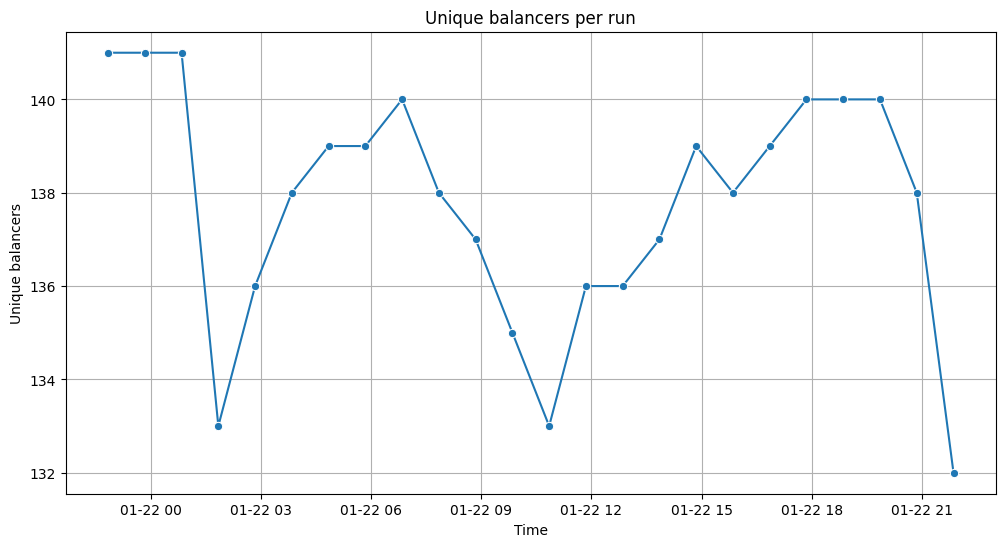

In [24]:
# Group by runs (gap > 20 mins)
stats = (
    df.sort("timestamp")
    .with_columns(
        # Identify gaps larger than 20 minutes (1200 seconds)
        # Use fill_null(0) to treat the first row as NO gap, keeping it in the first group
        (pl.col("timestamp").diff().fill_null(0) > (20 * 60)).cum_sum().alias("run_id")
    )
    .group_by("run_id")
    .agg([
        pl.col("timestamp").min().alias("start_time"),
        pl.col("balancerId").n_unique().alias("unique_balancers"),
        pl.len().alias("requests")
    ])
    .with_columns(
        # Convert unix timestamp to datetime
        pl.from_epoch(pl.col("start_time").cast(pl.Int64), time_unit="s").alias("start_time_dt")
    )
    .sort("start_time")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=stats, x="start_time_dt", y="unique_balancers", marker="o")
plt.title("Unique balancers per run")
plt.xlabel("Time")
plt.ylabel("Unique balancers")
plt.grid(True)
plt.show()

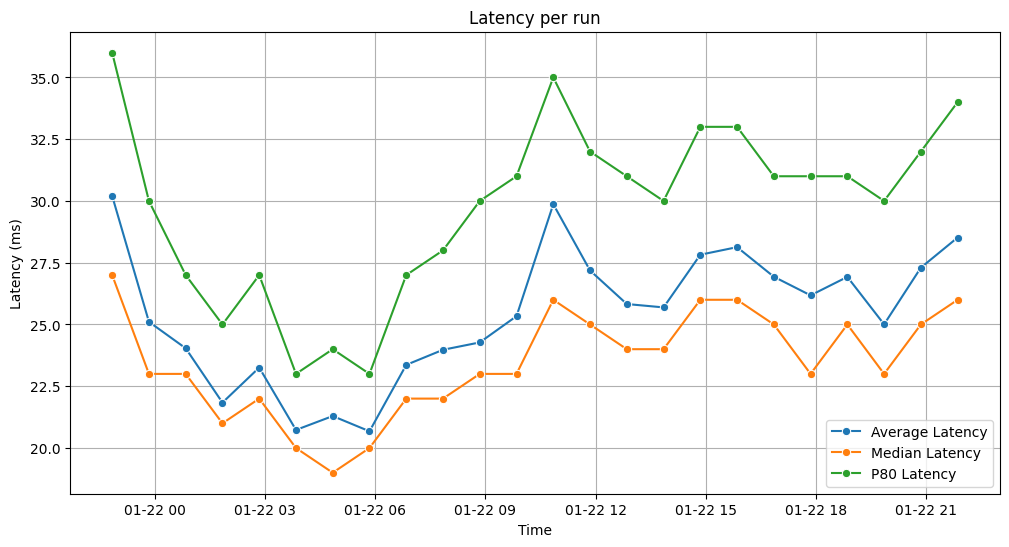

In [25]:
latency_stats = (
    df.sort("timestamp")
    .with_columns(
        (pl.col("timestamp").diff().fill_null(0) > (20 * 60)).cum_sum().alias("run_id")
    )
    .group_by("run_id")
    .agg([
        pl.col("timestamp").min().alias("start_time"),
        pl.col("latencyTotal").mean().alias("avg_latency"),
        pl.col("latencyTotal").median().alias("median_latency"),
        pl.col("latencyTotal").quantile(0.80).alias("p80_latency")
    ])
    .with_columns(
        pl.from_epoch(pl.col("start_time").cast(pl.Int64), time_unit="s").alias("start_time_dt")
    )
    .sort("start_time")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=latency_stats, x="start_time_dt", y="avg_latency", marker="o", label="Average Latency")
sns.lineplot(data=latency_stats, x="start_time_dt", y="median_latency", marker="o", label="Median Latency")
sns.lineplot(data=latency_stats, x="start_time_dt", y="p80_latency", marker="o", label="P80 Latency")
plt.title("Latency per run")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.legend()
plt.show()